<a href="https://colab.research.google.com/github/jgait/DSPS_WGaither/blob/main/HW4.5/Fitting_to_Afterglow_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import pylab as pl
import numpy as np

In [102]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [103]:
grbAG.tail() # Interesting NaN errors

,filter,time,mag,magerr,upperlimit
114,W1,63738,21.20,NaN,1
115,M2,74798,21.59,NaN,1
116,U,128928,20.05,NaN,1
117,V,971360,22.09,NaN,1
118,V,1171176,21.16,NaN,1


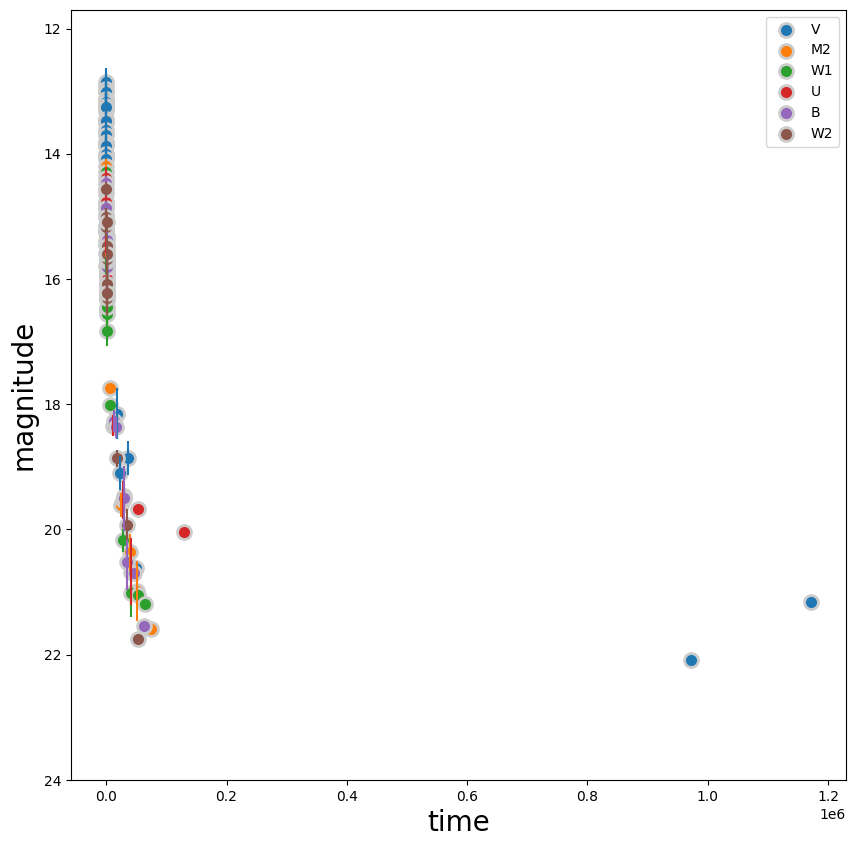

In [104]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

In [105]:
grbAG['log_time'] = np.log(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,log_time
0,V,66,13.21,0.24,0,4.189655
1,V,67,12.90,0.23,0,4.204693
2,V,68,12.86,0.23,0,4.219508
3,V,69,13.01,0.23,0,4.234107
4,V,70,12.97,0.23,0,4.248495


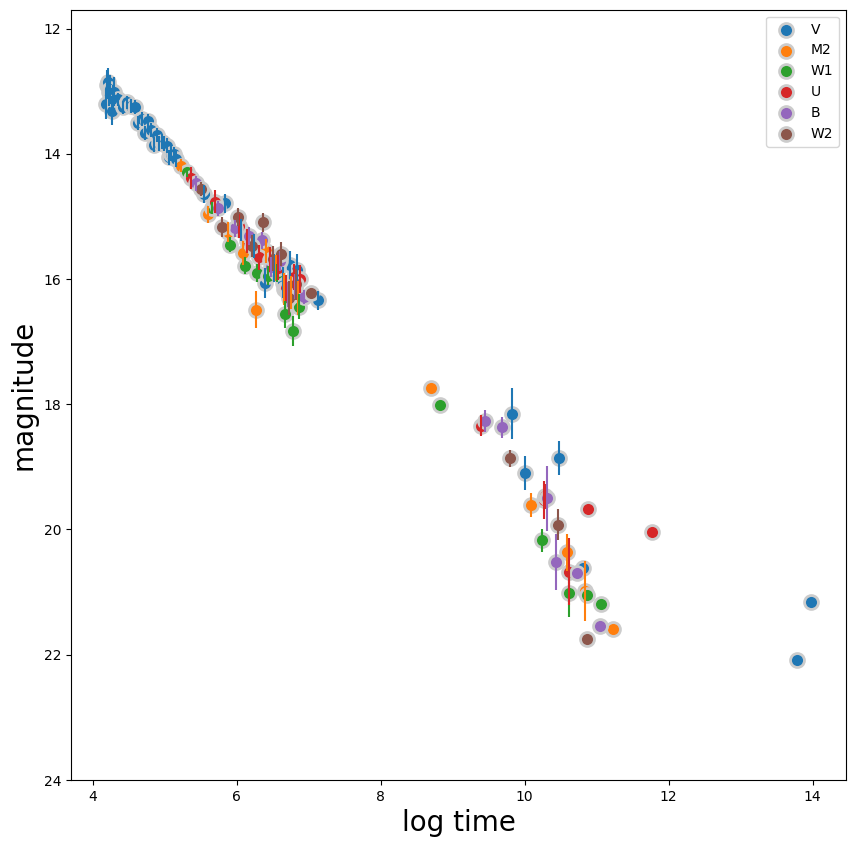

In [106]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "log_time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "log_time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

# Direct Solve

In [107]:
grbAG = grbAG[grbAG['upperlimit'] == 0]

x = grbAG['log_time'].values
X = np.c_[np.ones(len(x)), x]

y = grbAG['mag'].values

In [108]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print("Best fit --> b = {:.2f}, a = {:.2f}".format(*theta_best))
print("b: intercept \na: slope")

Best fit --> b = 8.58, a = 1.09
b: intercept 
a: slope


# SK learn lin regression

In [109]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y)

print("Best fit params from sklearn are intercept: {:.2f} slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

Best fit params from sklearn are intercept: 8.58 slope 1.09


# Gradient Descent - minimizing the L1 objective function

In [110]:
from scipy.optimize import minimize

def line (intercept, slope, x):
  return slope * x + intercept

def of(args, x, y):
  intercept, slope = args
  return sum(np.abs(y - line(intercept, slope, x)))


In [111]:
initial = (10, 2)
l1Soln = minimize(of, initial, args=(x,y))

In [112]:
print("Best fit params with L1 OF are slope: {:.2f} and intercept: {:.2f}".format(*l1Soln.x))

Best fit params with L1 OF are slope: 8.23 and intercept: 1.15


# L2 objective

In [113]:
def of(args, x, y):
  intercept, slope = args
  return sum(np.square(y - line(intercept, slope, x)))

initial = (10, 2)
l2Soln = minimize(of, initial, args=(x,y))

print(l2Soln)
print("\nBest fit params with L2 OF are slope: {:.2f} and intercept: {:.2f}".format(*l2Soln.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500728852
        x: [ 8.583e+00  1.091e+00]
      nit: 4
      jac: [ 7.153e-07 -2.384e-06]
 hess_inv: [[ 6.254e-02 -8.815e-03]
            [-8.815e-03  1.342e-03]]
     nfev: 18
     njev: 6

Best fit params with L2 OF are slope: 8.58 and intercept: 1.09


# Use test and train datasets

Out of class portion

In [116]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

reg = LinearRegression()

# Training Dataset
train_fit = reg.fit(x_train, y_train)
train_score = reg.score(x_train, y_train)
print("For training dataset slope: {:.2f} intercept: {:.2f}".format(reg.coef_[1], reg.intercept_))
print("Training score: {:.4}".format(train_score))

For training dataset slope: 1.08 intercept: 8.66
Training score: 0.9717


In [117]:
# Don't retrain so we are testing against the same fit
test_score = reg.score(x_test, y_test)
print("Test score: {:.4}".format(train_score))

Test score: 0.9717


This reveals that we have a well trained model which maintains a high score over both the training and test data sets